# **Regression Analysis for Predicting Success on College Exams**

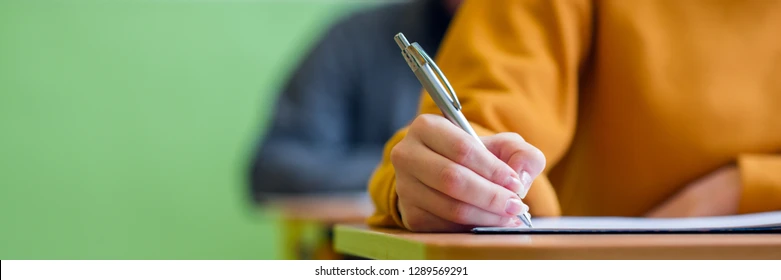

## **Business Understanding**


## **Data Understanding**




### **Collect Initial Data**

In [198]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree


%matplotlib inline

In [144]:
#Collect inititial data - Load data into analysis tool
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')

### **Describe Data**

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [146]:
data.isna().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [147]:
data = data.dropna()

In [148]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [149]:
for col in numericals:
    print(data[col].describe())
    print()

count    6378.000000
mean       19.977109
std         5.985460
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        44.000000
Name: Hours_Studied, dtype: float64

count    6378.000000
mean       80.020853
std        11.550723
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: Attendance, dtype: float64

count    6378.000000
mean        7.034964
std         1.468033
min         4.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: Sleep_Hours, dtype: float64

count    6378.000000
mean       75.066165
std        14.400389
min        50.000000
25%        63.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Previous_Scores, dtype: float64

count    6378.000000
mean        1.495296
std         1.233984
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Tutoring_

In [150]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64

Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64

Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64

Distance_from_Home
Near        3801
Moderate    1941
Fa

### **Explore Data**

In [151]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"].sort_values(ascending=False)

,Exam_Score
Exam_Score,1.000000
Attendance,0.580259
Hours_Studied,0.445104
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148
Sleep_Hours,-0.017171


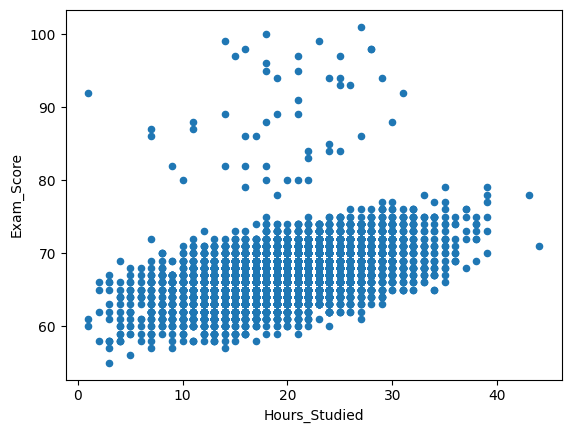

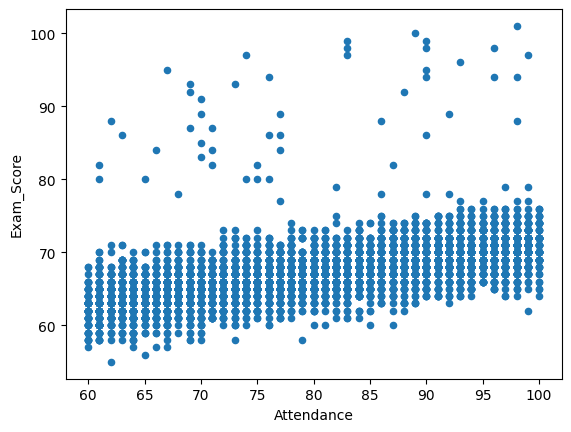

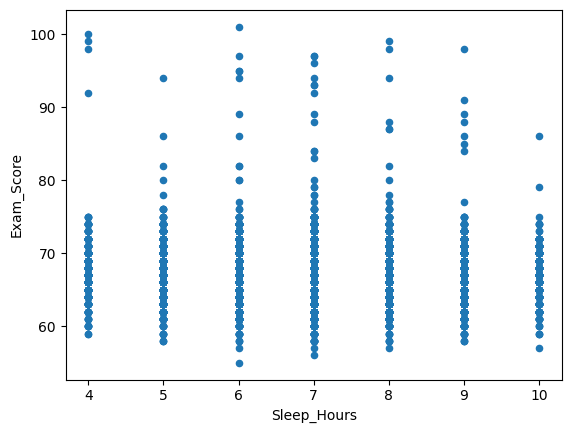

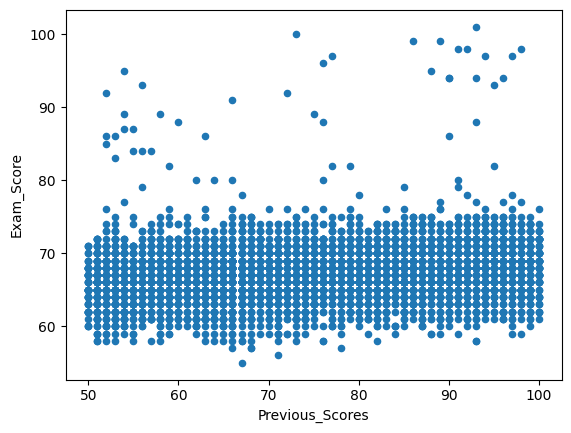

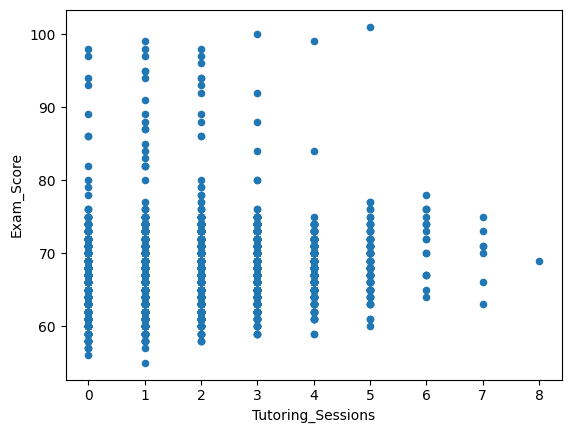

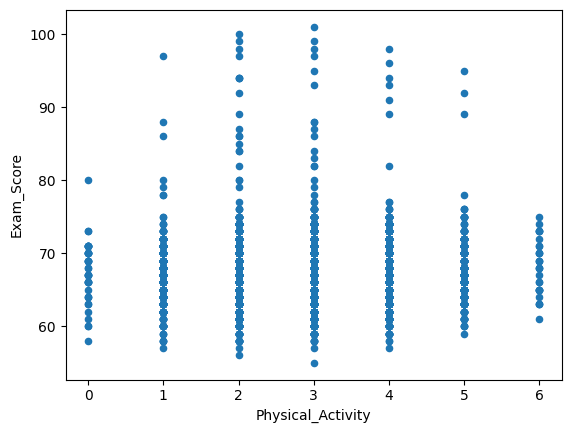

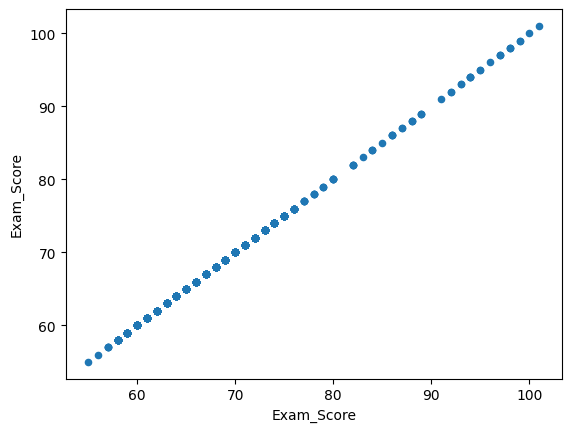

In [152]:
for col in data.corr(numeric_only=True).columns:
    data.plot.scatter(x=col, y='Exam_Score')

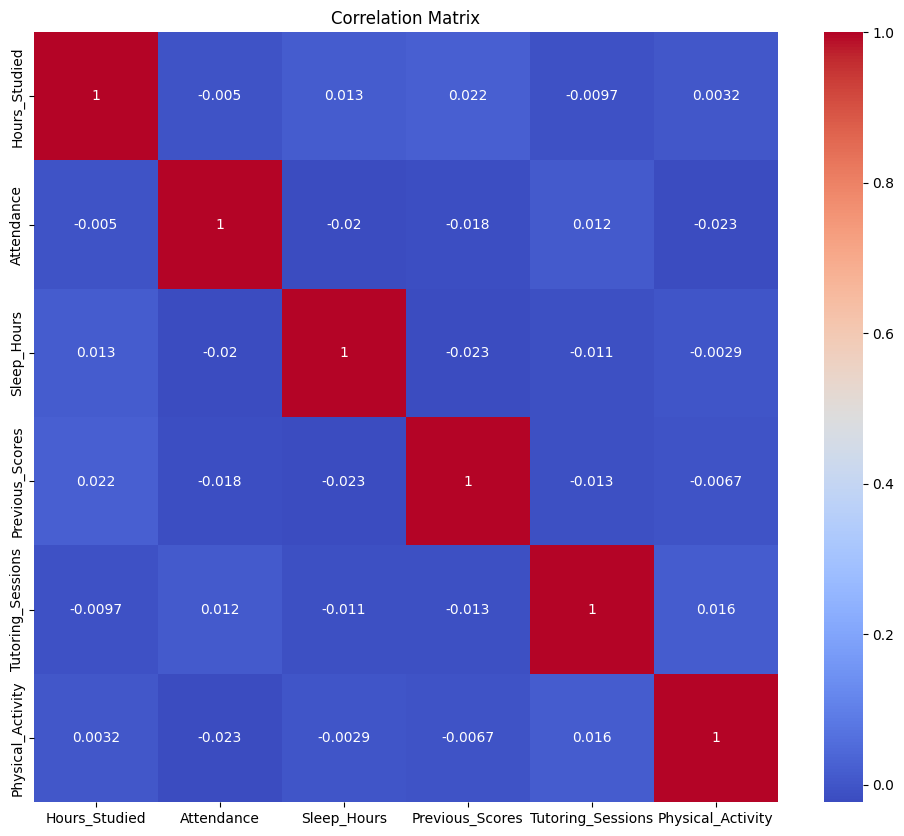

In [153]:
correlation_matrix = numericals.drop(columns='Exam_Score').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [154]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Source: [Stack Overflow](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792)

In [155]:
# Iterate over each categorical column and calculate Cramér's V with 'Exam_Score'
cramers_v_scores = {}
for col in categoricals.columns:
    cramers_v_scores[col] = cramers_v(categoricals[col], data['Exam_Score'])

    # Sort the Cramér's V scores in descending order
sorted_cramers_v = dict(sorted(cramers_v_scores.items(), key=lambda x: x[1], reverse=True))

# Print the sorted Cramér's V scores
for col, score in sorted_cramers_v.items():
    print(f"{col}: {score}")

Access_to_Resources: 0.14141624384893206
Parental_Involvement: 0.12643554349868558
Learning_Disabilities: 0.12443093706886459
Parental_Education_Level: 0.08367163464587528
Peer_Influence: 0.07760455590870957
Distance_from_Home: 0.07642238156014759
Internet_Access: 0.06822152279146197
Motivation_Level: 0.06516068475806391
Family_Income: 0.06448738612047515
Extracurricular_Activities: 0.06374559401534015
Teacher_Quality: 0.05178274514643499
Gender: 0.037226928401334625
School_Type: 0.0


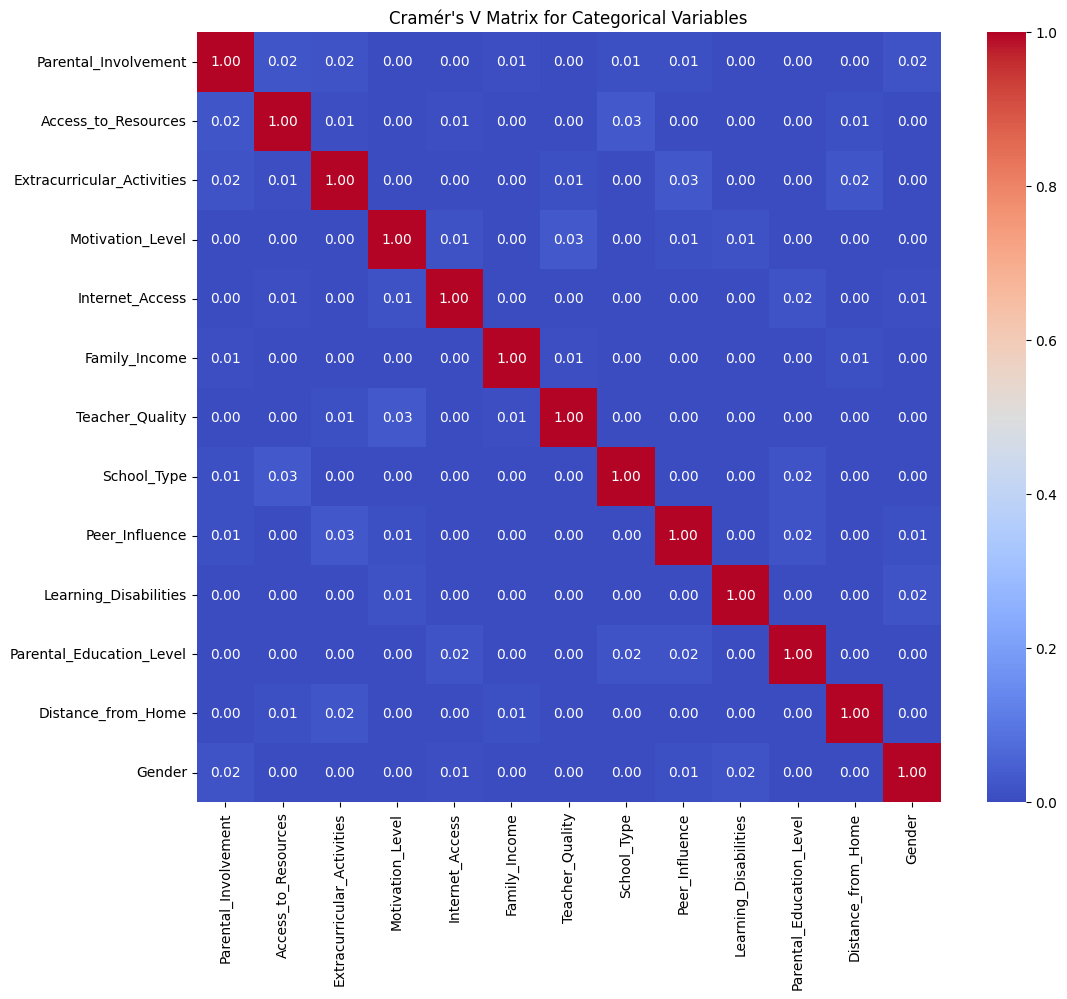

In [156]:
# Create an empty matrix to store Cramer's V values
cramers_v_matrix = pd.DataFrame(index=categoricals.columns, columns=categoricals.columns)

# Iterate through all pairs of categorical columns
for col1 in categoricals.columns:
    for col2 in categoricals.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(categoricals[col1], categoricals[col2])

# Convert the Cramér's V matrix to numeric type
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cramér\'s V Matrix for Categorical Variables')
plt.show()

### **Data Preparation**

In [157]:
#fit a one hot encoder to the categorical
ohe = OneHotEncoder(drop='first')
categoricals_trans = ohe.fit_transform(categoricals)

In [158]:
#create a matrix from the transformed categorical data
categoricals_trans.todense()

matrix([[1., 0., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 1., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 1., 1.]])

In [159]:
#turn the matrix into a dataframe
categoricals_ohe = pd.DataFrame(categoricals_trans.todense(), columns=ohe.get_feature_names_out())

In [160]:
#combine the reformated categorical columns with the numerical columns
data = pd.concat([numericals, categoricals_ohe], axis=1)

In [161]:
data = data.dropna()

In [162]:
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Modeling**

In [164]:
#Prints Results of Regression Metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Function Source: [Stack Overflow](https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does)

In [165]:
#Create a single linear regression model using only the most correlated variable as a baseline
single_linear_regression = sm.OLS(endog=y_train, exog=sm.add_constant(X_train[['Attendance']]))
single_linear_regression_results = single_linear_regression.fit()
print(single_linear_regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     2470.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:09:20   Log-Likelihood:                -12714.
No. Observations:                4929   AIC:                         2.543e+04
Df Residuals:                    4927   BIC:                         2.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6834      0.317    163.070      0.0

In [166]:
slr = LinearRegression()
slr.fit(X_train[['Attendance']], y_train)
y_pred = slr.predict(X_train[['Attendance']])
regression_results(y_train, y_pred)

explained_variance:  0.3339
mean_squared_log_error:  0.002
r2:  0.3339
MAE:  2.1295
MSE:  10.1874
RMSE:  3.1918


In [167]:
multiple_lin_reg = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))
multiple_lin_reg_results = multiple_lin_reg.fit()
multiple_lin_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     262.2
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:09:20   Log-Likelihood:                -11513.
No. Observations:                4929   AIC:                         2.308e+04
Df Residuals:                    4901   BIC:                         2.326e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    41.2607      0.472     87.367      0.000      40.335      42.187
Hours_Studied                             0.2911      0.006     48.485      0.000       0.279       0.303
Attendance                                0.1973      0.003     63.925      0.000       0.191       0.203
Sleep_Hours                              -0.0117      0.024     -0.481      0.630      -0.060       0.036
Previous_Scores                           0.0474      0.002     19.015      0.000       0.043       0.052
Tutoring_Sessions                         0.4995      0.029     17.271      0.000       0.443       0.556
Physical_Activity                         0.1338      0.035      3.840      0.000       0.065       0.202
Parental_Involvement_Low                  0.2521      0.104      2.421      0.016       0.048       0.456
Parental_Involvement_Medium               0.0151      0.083      0.181      0.856      -0.148       0.178
Access_to_Resources_Low                   0.0177      0.103      0.171      0.864      -0.185       0.220
Access_to_Resources_Medium               -0.0154      0.083     -0.185      0.853      -0.178       0.147
Extracurricular_Activities_Yes            0.0778      0.073      1.066      0.286      -0.065       0.221
Motivation_Level_Low                     -0.0566      0.104     -0.546      0.585      -0.260       0.147
Motivation_Level_Medium                  -0.1092      0.095     -1.152      0.249      -0.295       0.077
Internet_Access_Yes                      -0.0040      0.134     -0.030      0.976      -0.267       0.259
Family_Income_Low                        -0.0456      0.099     -0.460      0.646      -0.240       0.149
Family_Income_Medium                     -0.1237      0.099     -1.244      0.214      -0.319       0.071
Teacher_Quality_Low                      -0.1340      0.131     -1.021      0.307      -0.391       0.123
Teacher_Quality_Medium                   -0.2216      0.080     -2.775      0.006      -0.378      -0.065
School_Type_Public                       -0.0910      0.078     -1.163      0.245      -0.244       0.062
Peer_Influence_Neutral                    0.1454      0.097      1.505      0.132      -0.044       0.335
Peer_Influence_Positive                   0.1411      0.096      1.464      0.143      -0.048       0.330
Learning_Disabilities_Yes                -0.0466      0.117     -0.399      0.690      -0.275       0.182
Parental_Education_Level_High School      0.0347      0.083      0.420      0.675      -0.128       0.197
Parental_Education_Level_Postgraduate    -0.0200      0.103     -0.194      0.846      -0.222       0.182
Distance_from_Home_Moderate              -0.1337      0.131     -1.019      0.308      -0.391       0.123
Distance_

In [168]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_train)
regression_results(y_train, y_pred)

explained_variance:  0.5909
mean_squared_log_error:  0.0011
r2:  0.5909
MAE:  1.3239
MSE:  6.257
RMSE:  2.5014


In [192]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_train)
regression_results(y_train, y_pred_rf)

explained_variance:  0.9315
mean_squared_log_error:  0.0002
r2:  0.9314
MAE:  0.5693
MSE:  1.0487
RMSE:  1.0241


In [170]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
regression_results(y_train, y_pred)

explained_variance:  0.6662
mean_squared_log_error:  0.0009
r2:  0.666
MAE:  1.2821
MSE:  5.1081
RMSE:  2.2601


In [171]:
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)
y_pred = ransac.predict(X_train)
regression_results(y_train, y_pred)

explained_variance:  0.4945
mean_squared_log_error:  0.0015
r2:  0.4902
MAE:  1.6508
MSE:  7.7975
RMSE:  2.7924


In [172]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_train)
regression_results(y_train, y_pred)

explained_variance:  0.5782
mean_squared_log_error:  0.0012
r2:  0.5765
MAE:  1.3596
MSE:  6.4765
RMSE:  2.5449


In [174]:
X_train_sig = X_train.drop(columns=['Sleep_Hours', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes',
                                    'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low',
                                    'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School',
                                    'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Male'])

In [175]:
random_forest_sig = RandomForestRegressor()
random_forest_sig.fit(X_train_sig, y_train)
y_pred = random_forest_sig.predict(X_train_sig)
regression_results(y_train, y_pred)


explained_variance:  0.9292
mean_squared_log_error:  0.0002
r2:  0.9292
MAE:  0.5726
MSE:  1.0832
RMSE:  1.0408


In [176]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [177]:
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [180]:
rf_best_paramss = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=3, max_depth=90)
rf_best_paramss.fit(X_train, y_train)
y_pred = rf_best_paramss.predict(X_train)
regression_results(y_train, y_pred)

explained_variance:  0.6449
mean_squared_log_error:  0.001
r2:  0.6449
MAE:  1.3975
MSE:  5.4303
RMSE:  2.3303


In [179]:
rf_baseline = RandomForestRegressor()
rf_baseline.fit(X, y)
y_pred = rf_baseline.predict(X)
regression_results(y, y_pred)

explained_variance:  0.9367
mean_squared_log_error:  0.0002
r2:  0.9366
MAE:  0.5605
MSE:  0.9637
RMSE:  0.9817


In [181]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)

In [182]:
rf_scaled = RandomForestRegressor()
rf_scaled.fit(X_train_scaled, y_train)
y_pred = rf_scaled.predict(X_train_scaled)
regression_results(y_train, y_pred)

explained_variance:  0.9317
mean_squared_log_error:  0.0002
r2:  0.9317
MAE:  0.5702
MSE:  1.045
RMSE:  1.0222


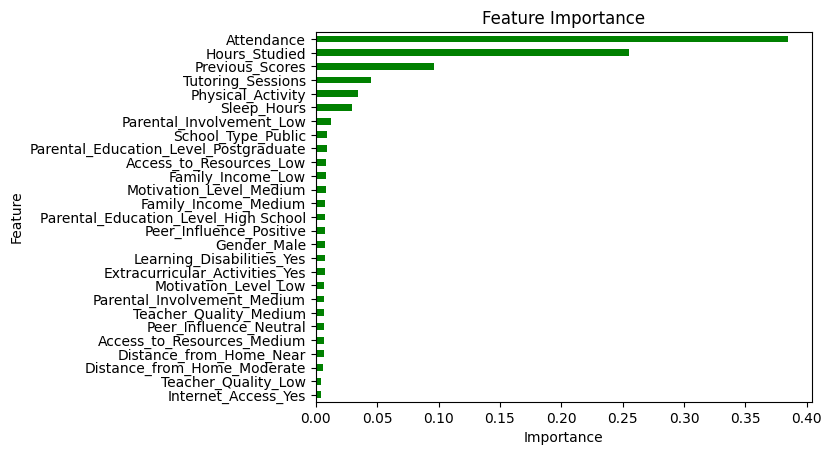

In [191]:
global_importance = pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values(ascending=True,)
global_importance.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

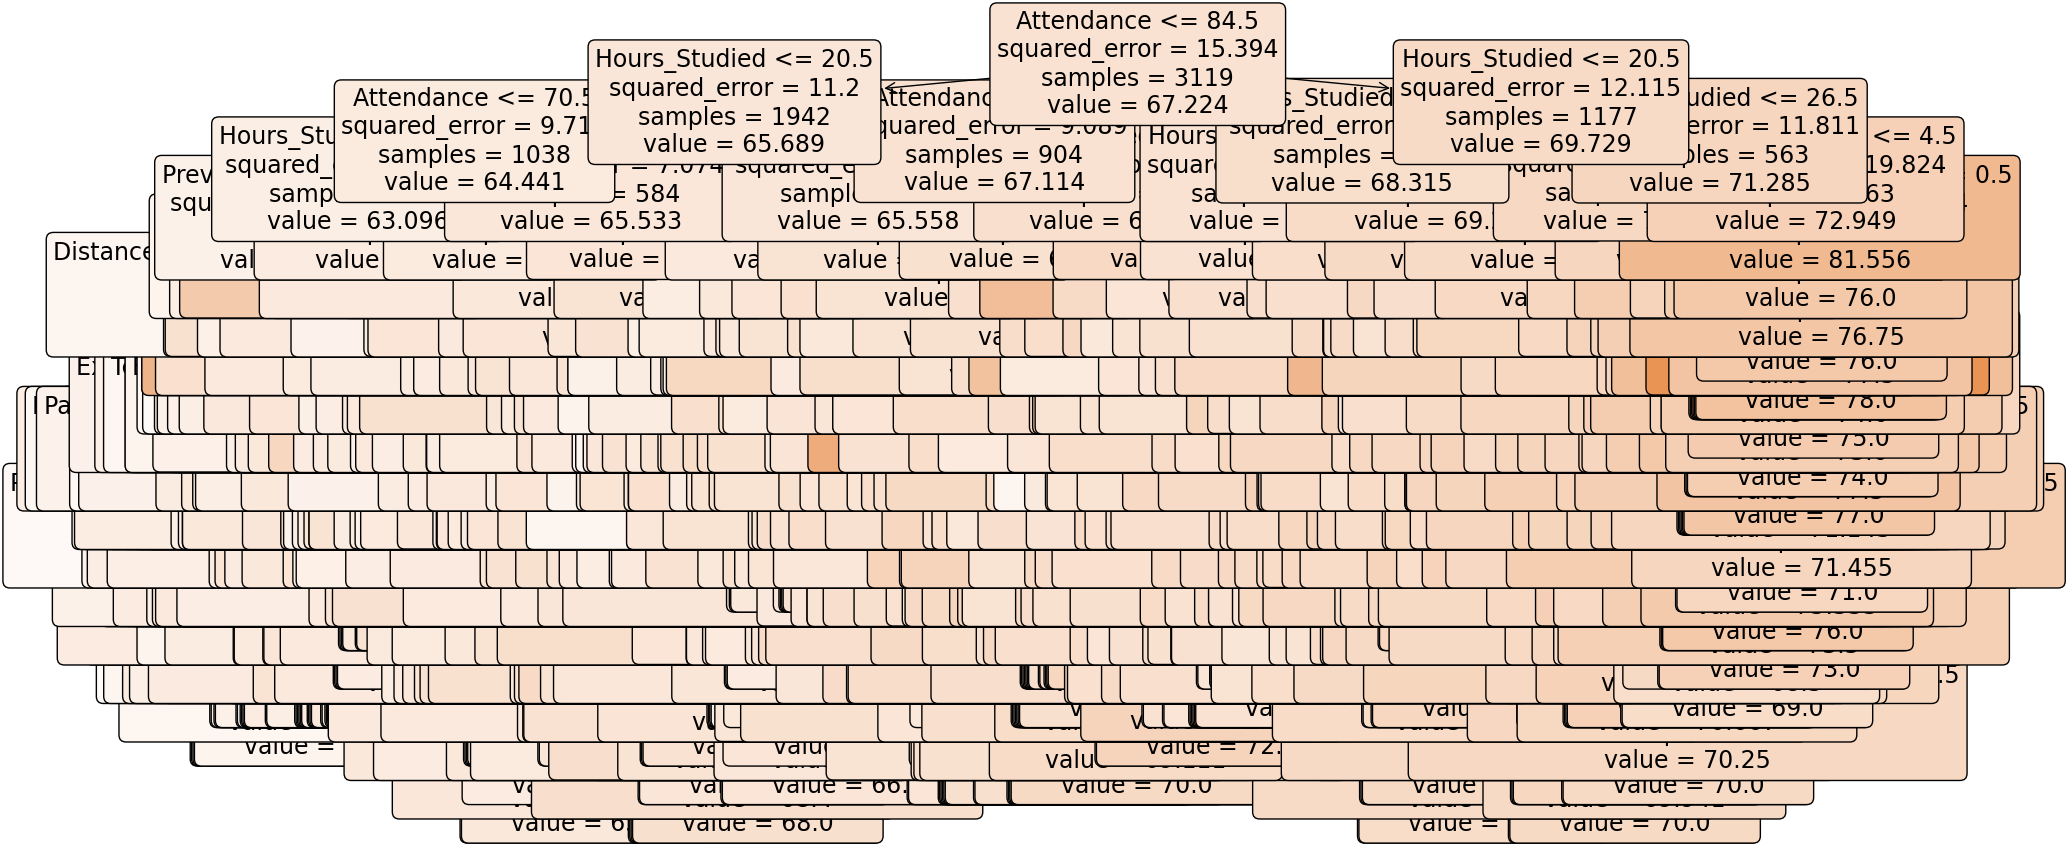

In [199]:
tree_to_plot = random_forest.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree_to_plot, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=17)
plt.show()